# Forest Cover Type Prediction
#### Team: Clear-Cut Solution: Kevin Martin, Yang Jing, Justine Schabel

In [5]:
#run this cell to intal xgboost if you are using the container.
!pip install xgboost

     |████████████████████████████████| 148.9 MB 141 kB/s eta 0:00:011  |▌                               | 2.5 MB 2.3 MB/s eta 0:01:05     |███▉                            | 18.0 MB 11.7 MB/s eta 0:00:12     |████████████                    | 56.2 MB 9.8 MB/s eta 0:00:10     |██████████████▌                 | 67.7 MB 12.6 MB/s eta 0:00:07     |█████████████████████▋          | 100.7 MB 2.4 MB/s eta 0:00:21     |███████████████████████         | 107.4 MB 8.7 MB/s eta 0:00:05     |██████████████████████████████▎ | 140.9 MB 16.4 MB/s eta 0:00:01


## Introduction

This project was from a Kaggle competion closed in 2014. 
[Link to Data page on Kaggle](https://www.kaggle.com/c/forest-cover-type-prediction/data)

The objective is to classify trees from four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. The "labels" are 7 "cover types". They are: 

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

The training set (15120 observations) contains both features and the labels. The test set contains only the features. Compared to the training set, the test set is very large with 565892 observations. 

There are 54 features, include 40 soil types (binary), 4 wilderness ares (binary), and 10 numerical features, such as Elevation, slope, aspects and distances to certain points.

We quickly noticed that the training data size is less than 3% of the testign data. We might not have enough diversites in the training data to predict the labels for testign data. We also noticed that 100% accuracy was achieved in this Kaggle competion previously, but that appeared to due to a "cheat" already known to the Kaggle team. As such, our objective is not to obsess over the accuracy of the "testing data", but to explore which classficiation algorithm and/or process works best for the dataset. In addition, some "cover types" appear to be easy to confuse, such as "spruce/fir" and "lodgpole pine". We confirmed this suspicsion by performing exploratory data analysis first. Our EDA is documented in the "explanatory_data_analysis" notebook. To imporve model performance, we need to find a way to bettr differentiate between type 1 and 2. 

Due to the perceived higher confusion rate between type 1 ad type 2 trees from the EDA, and between type 3 and 6 trees, we performed a separate training on these 2 subsets. We also performed other feature engineering steps, which include scaling numerical features, power-transfomration of "elevation" and dropping some less frequent soil types or "distance" related features. In addition, dFor better organizaiton of the code, we saved all the feature engineering functions under a separate module, called "feature_engineering.py".

In addition, to make the computing environment portable and enable collaboration among team members, we created a docker container based on the image "jupyter/tensorflow-notebook". Details about the container is documented in the "readme.md" file. 

This noteboook documents the model development, evluation and final testing process. In each section, we included a flowchart to summarize the feature engineering applied and modeling processes. We experimented with different algorithms, including KNN, Random Forest, Logistic Regression, Adaboost, Gradient Boosting(XGBoost), and neural networks(MLP). Without separate training, the accuracy for "dev data" from both MLP and XGBoost was already in 84%-86% range. With separately trained sub-models, the accuracy for "dev data" from both MLP and XGBoost models was above 90%. However, when applied to the "testing data", the accuracy dropped to 74%. We suspect that it's mainly due to the small training data size,and the model is overfitting. To include more observations in the training data, we used 90/10 split instead of 80/20. And, to counter the impact of overfitting, we used "max_depth=1" in training the Random Forest model. While this decreased the Randome Forest model accuracy for the dev data to 40%, it works well in our manual ensemble to serve as a disserting vote. Our final model is based on a manual ensemble where we take the majority vote of the predictions from the top 5 performing algorithms (KNN, Random Forest, Adaboost, XGBoost and MLP) for this use case. Where there is a tie, we took the prediction from the XGboost model. This manual ensemble model is documented in the "model.py" file.  In the end, we achieved over 94% accuracy on the dev data and over 76% accuracy on the testing data. 


## Initial Setup
#### Import Required Libraries

In [6]:
# Surpress warning messages
import warnings
warnings.filterwarnings("ignore")

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Libraries for reading, cleaning and plotting the dataa
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import numpy as np

# Feature Engineering was written by the team 
import feature_engineering as fe

# Models was written by the team 
import models 


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xg


# So we can reload packages without restarting the kernel
import importlib

In [7]:
# If you update the feature_engineering package, run this line so it updates without needing to restart the kernel
importlib.reload(fe)

<module 'feature_engineering' from '/home/jovyan/work/feature_engineering.py'>

#### Load Data

In [8]:
# Read in training data 
train_df = pd.read_csv("data/train.csv")

## Feature Engineering 

Overall Data Pipeline
<img src="data/data_pipeline.png">


The following transformations were made in the function below. 

#### Transform Hillshade
Now we'll normalize the "Hillsdale" variables by dividing them by 255. The hillshade variables contain index of shades with a value between 0 and 255. 

#### Create new soil types
Now we'll create additional features to magnify the differences betweeen cover type1 and 2, and covery type3 and 6.

#### Combine soil types 

#### Drop rare or non-existant soil types 
Now we'll drop soil types that don't exist in the training set. Then we will combine soil types 35, 38, 39 and 40 because they have a very similar distribution. 

#### Create new features based on soil type descriptions 
TODO: Explain how we split up soil descriptions into different features to account for overlap.

#### Transform Aspect
TODO: Explain aspect problem and solution

#### Log transformations
Per EDA, we noticed the distribution of the "distance" related variables are skewed. Now we'll log transform the features related to the distances to make the distribution smoother, and thus decrease the variances of the predictions.

#### Add polynomial features
Per EDA, Elevation is a numerical variable and there is a clearer distinciton in Elevation among the dependenet variable, cover type. To imporve the signal, we sqaured Elevation. 

#### Drop irrelevant or problematic features
- We'll drop "Id" because it does not provide any meaning in the classifications.
- We'll drop "Hillshade_9am" because it has a high correlation with "Aspect" and "Hillshade_3pm".
- We'll also drop "Vertical_Distance_To_Hydrology" because it does not show much distinction among the "Cover Types" and has a very skewed distribution, with negative values in some cases. The variable offers little insight and there might be data issues in this variable. 


In [9]:
# Apply (data independent) feature engineering to entire dataset 
train_df  = fe.manipulate_data(train_df)
# Examine transformed data
train_df.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,ap_ew,ap_ns,Elevation_squared
0,2596,3,5.556828,6.236370,0.909804,0.580392,8.745125,1,0,0,...,0,0,0,0,0,0,5,0.777146,0.629320,6739216
1,2590,2,5.361292,5.968708,0.921569,0.592157,8.736489,1,0,0,...,0,0,0,0,0,0,5,0.829038,0.559193,6708100
2,2804,9,5.594711,8.064951,0.933333,0.529412,8.719644,1,0,0,...,0,0,0,0,0,0,2,0.656059,-0.754710,7862416
3,2785,18,5.493061,8.036250,0.933333,0.478431,8.734238,1,0,0,...,0,0,0,0,0,0,2,0.422618,-0.906308,7756225
4,2595,2,5.036953,5.971262,0.917647,0.588235,8.727940,1,0,0,...,0,0,0,0,0,0,5,0.707107,0.707107,6734025


Now that the data is transformed, we can also visualize the new aspect features. 

#### Drop Unseen or low frequency Soil Types 

In [10]:
train_df = fe.drop_unseen_soil_types(train_df)

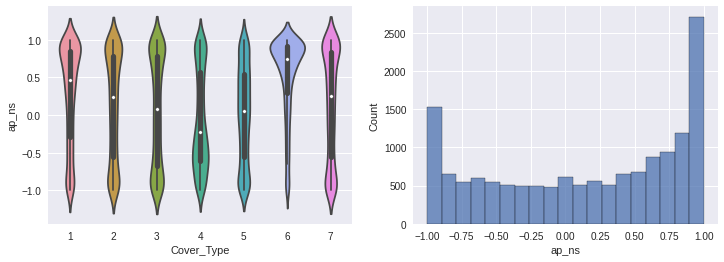

In [11]:
# Visualize cover type VS the cosine of Aspect degerees
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
sns.violinplot(x=train_df['Cover_Type'],y=train_df['ap_ns'],ax=ax1)
sns.histplot(train_df['ap_ns'],ax=ax2)
plt.show()

After the feature transformation, we see improved distinction in median values, espeically for cover type 6, where the median is notably higher than that of other cover types and the distribution is concentrated around the median.

#### Segment data

Based on closer examination of our model performance, we found that the models consistently confused cover types 1 and 2 and covertypes 3 and 6. So we decided to break up our model into one primary model (outputs 12 (for 1 or 2), 36 (for outputs 3 or 6), 4, 5 or 7) and two secondary models (one for distinguishing 1 or 2 and the other for distinguishing 3 or 6). 

In [12]:
# Split trainning data into subsets to improve model accurracy with cover type 1&2, and 3&6.
train_df_original, train_df_12_36_4_5_7, train_df_12, train_df_36 = fe.subset_data(train_df)

#### Split data into train/dev

Then, we split the training data into a training data set (90%) and development data set (10%). We will also have a large, separate test data set. 

In [13]:
# Only (randomly) sample indicies once for the entire dataset 
# This will be very important for comparing the output to the original dev labels 
train_indicies_all_data = list(train_df_original.sample(frac=0.9).index)

# Split each dataset into 80% train and 20% dev by randomly sampling indicies 
train_data_original, train_labels_original, dev_data_original, dev_labels_original = fe.split_data(train_df_original,train_indicies_all_data)
train_data_12_36_4_5_7, train_labels_12_36_4_5_7, dev_data_12_36_4_5_7, dev_labels_12_36_4_5_7 = fe.split_data(train_df_12_36_4_5_7,train_indicies_all_data)
train_data_cover_type_12, train_labels_cover_type_12, dev_data_cover_type_12, dev_labels_cover_type_12  = fe.split_data(train_df_12,list(train_df_12.sample(frac=0.8).index))
train_data_cover_type_36, train_labels_cover_type_36, dev_data_cover_type_36, dev_labels_cover_type_36  = fe.split_data(train_df_36,list(train_df_36.sample(frac=0.8).index))

#### Scale the data to have a mean of 0 and a variance of 1.

In [14]:
standardize_features = ['Elevation','Slope', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points','Elevation_squared']

# Retrieve scaler *once* for the original training data so we don't overfit the smaller datasets 
train_data_original, train_data_original_scaler = fe.scale_training_data(standardize_features, train_data_original, scaler_type="standard")
dev_data_original = fe.scale_non_training_data(standardize_features, dev_data_original, train_data_original_scaler)

train_data_12_36_4_5_7 = fe.scale_non_training_data(standardize_features, train_data_12_36_4_5_7, train_data_original_scaler)
dev_data_12_36_4_5_7 = fe.scale_non_training_data(standardize_features, dev_data_12_36_4_5_7, train_data_original_scaler)

train_data_cover_type_12 = fe.scale_non_training_data(standardize_features, train_data_cover_type_12, train_data_original_scaler)
dev_data_cover_type_12 = fe.scale_non_training_data(standardize_features, dev_data_cover_type_12, train_data_original_scaler)

train_data_cover_type_36 = fe.scale_non_training_data(standardize_features, train_data_cover_type_36, train_data_original_scaler)
dev_data_cover_type_36 = fe.scale_non_training_data(standardize_features, dev_data_cover_type_36, train_data_original_scaler)

#### Apply PCA to reduce dimensionality of numerical variables after scaling

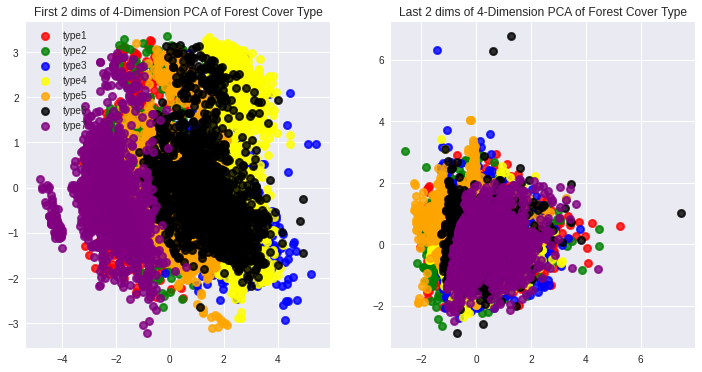

In [15]:
def pca_fe(data=train_data_original,labels=train_labels_original):
    num_cols = ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points','ap_ew', 'ap_ns', 'Elevation_squared']
    pca = PCA(n_components=4) 
    new_x = pca.fit_transform(data[num_cols])
    new_dev = pca.transform(dev_data_original[num_cols])
    pca_df = pd.DataFrame(data=new_x, index=data.index,columns=["pca_fe1","pca_fe2","pca_fe3","pca_fe4"])
    pca_dev_df = pd.DataFrame(data=new_dev, index=dev_labels_original.index,columns=["pca_fe1","pca_fe2","pca_fe3","pca_fe4"])
    new_data = pd.concat((data.drop(columns=num_cols),pca_df),axis=1)
    new_dev_data = pd.concat((dev_data_original.drop(columns=num_cols),pca_dev_df),axis=1)
    y =  labels
    zip(new_x,y)
    
    colors = ["red","green","blue","yellow","orange","black","purple"]
    target_names = ['type' +str(i) for i in range(1,8)] # labels
      
    fig, axes = plt.subplots(1,2, figsize=(12,6))
    lw = 2
    for i,color, target_name in zip([1,2,3,4,5,6,7], colors,target_names):
        axes[0].scatter(new_x[y==i,0],new_x[y==i,1], color=color, alpha=.8, lw=lw,label=target_name)
        axes[1].scatter(new_x[y==i,2],new_x[y==i,3], color=color, alpha=.8, lw=lw,label=target_name)
    axes[0].legend(loc='best', shadow=False, scatterpoints=1)
    axes[0].set_title('First 2 dims of 4-Dimension PCA of Forest Cover Type')
    axes[1].set_title('Last 2 dims of 4-Dimension PCA of Forest Cover Type')     
    plt.show()
    
    return new_data, new_dev_data, pca
    

new_train_data,new_dev_data,pca = pca_fe()

#### Explore and confirm the shape of the data

In [16]:
print("Original Data with Labels 1,2,3,4,5,6,7")
print("Training data shape: {0} Training labels shape: {1}".format(train_data_original.shape, train_labels_original.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data_original.shape, dev_labels_original.shape))

print("Data with Labels 12,36,4,5,7")
print("Training data shape: {0} Training labels shape: {1}".format(train_data_12_36_4_5_7.shape, train_labels_12_36_4_5_7.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data_12_36_4_5_7.shape, dev_labels_12_36_4_5_7.shape))

print("Data with Labels 1,2")
print("Training data shape: {0} Training labels shape: {1}".format(train_data_cover_type_12.shape, train_labels_cover_type_12.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data_cover_type_12.shape, dev_labels_cover_type_12.shape))

print("Data with Labels 1,3")
print("Training data shape: {0} Training labels shape: {1}".format(train_data_cover_type_36.shape, train_labels_cover_type_36.shape))
print("Dev data shape: {0} Dev labels shape: {1}\n".format(dev_data_cover_type_36.shape, dev_labels_cover_type_36.shape))

Original Data with Labels 1,2,3,4,5,6,7
Training data shape: (13608, 48) Training labels shape: (13608,)
Dev data shape: (1512, 48) Dev labels shape: (1512,)

Data with Labels 12,36,4,5,7
Training data shape: (13608, 48) Training labels shape: (13608,)
Dev data shape: (1512, 48) Dev labels shape: (1512,)

Data with Labels 1,2
Training data shape: (3456, 48) Training labels shape: (3456,)
Dev data shape: (864, 48) Dev labels shape: (864,)

Data with Labels 1,3
Training data shape: (3456, 48) Training labels shape: (3456,)
Dev data shape: (864, 48) Dev labels shape: (864,)



## Models

Fit Random Forest, K Nearest Neighbors and Multilayer Perceptron models to the training data
<img src="data/training_models.png">

#### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Set model parameters
num_trees = 100
max_depth = 1

#fit a Random Forest Model on the original dataset
forest_model_original = RandomForestClassifier(num_trees, max_depth=max_depth,max_features="auto",random_state=1)
forest_model_original.fit(train_data_original, train_labels_original)

# Fit a Random Forest Model to all of the training data
forest_model_all_data = RandomForestClassifier(num_trees, max_depth=max_depth,max_features="auto",random_state=1)
forest_model_all_data.fit(train_data_12_36_4_5_7, train_labels_12_36_4_5_7)

# # Fit a Random Forest Model to differentiate cover types one and two
forest_model_cover_type_12 = RandomForestClassifier(num_trees, max_depth=max_depth,max_features="auto",random_state=1)
forest_model_cover_type_12.fit(train_data_cover_type_12, train_labels_cover_type_12)

# # Fit a Random Forest Model to differentiate cover types three and six
forest_model_cover_type_36 = RandomForestClassifier(num_trees, max_depth=max_depth,max_features="auto",random_state=1)
forest_model_cover_type_36.fit(train_data_cover_type_36, train_labels_cover_type_36)

RandomForestClassifier(max_depth=1, random_state=1)

#### Adaboost Ensemble

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Fit an Adaboost Model to all of the training data

clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),n_estimators=200,random_state=1,)

clf_ada.fit(train_data_original,train_labels_original)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8),
                   n_estimators=200, random_state=1)

#### Xgboost Ensemble

In [19]:
from xgboost import XGBClassifier
# Fit a XG Model to all of the training data
clf_xg = XGBClassifier(n_estimators=200,max_depth=8,random_state=1)
clf_xg.fit(train_data_original,train_labels_original)

# Fit a XGBoost Model to all of the training data
xgb_model_all_data = XGBClassifier(n_estimators=200,max_depth=8,random_state=1)
xgb_model_all_data.fit(train_data_12_36_4_5_7, train_labels_12_36_4_5_7)

# # Fit a XGBoost Model to differentiate cover types one and two
xgb_model_cover_type_12 = XGBClassifier(n_estimators=200,max_depth=8,random_state=1)
xgb_model_cover_type_12.fit(train_data_cover_type_12.to_numpy(), train_labels_cover_type_12)

# # Fit a XGBoost Model to differentiate cover types three and six
xgb_model_cover_type_36 = XGBClassifier(n_estimators=200,max_depth=8)
xgb_model_cover_type_36.fit(train_data_cover_type_36.to_numpy(), train_labels_cover_type_36)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### K-Nearest Neighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Set model parameters
num_neighbors = 1

clf_knn = KNeighborsClassifier(num_neighbors)
clf_knn.fit(train_data_original,train_labels_original)
# Fit a KNN Model to all of the training data
knn_model_all_data = KNeighborsClassifier(num_neighbors)
knn_model_all_data.fit(train_data_12_36_4_5_7, train_labels_12_36_4_5_7)

# Fit a KNN Model to differentiate cover types one and two
knn_model_cover_type_12 = KNeighborsClassifier(num_neighbors)
knn_model_cover_type_12.fit(train_data_cover_type_12, train_labels_cover_type_12)

# Fit a KNN Model to differentiate cover types three and six
knn_model_cover_type_36 = KNeighborsClassifier(num_neighbors)
knn_model_cover_type_36.fit(train_data_cover_type_36, train_labels_cover_type_36)

KNeighborsClassifier(n_neighbors=1)

#### Multi-Layer Perceptron

In [21]:
from sklearn.neural_network import MLPClassifier

# Set model parameters
alpha = 1e-3
hidden_layer_sizes = (200,)
random_state = 1
max_iter = 200

# Fit a MLP Model to all of the training data
mlp_model_all_data = MLPClassifier(alpha=alpha,hidden_layer_sizes=hidden_layer_sizes,random_state=random_state,max_iter=max_iter)
mlp_model_all_data.fit(train_data_12_36_4_5_7, train_labels_12_36_4_5_7)

# # Fit a MLP Model to differentiate cover types one and two
mlp_model_cover_type_12 = MLPClassifier(alpha=alpha,hidden_layer_sizes=hidden_layer_sizes,random_state=random_state,max_iter=max_iter)
mlp_model_cover_type_12.fit(train_data_cover_type_12, train_labels_cover_type_12)

# # Fit a MLP Model to differentiate cover types three and six
mlp_model_cover_type_36 = MLPClassifier(alpha=alpha,hidden_layer_sizes=hidden_layer_sizes,random_state=random_state,max_iter=max_iter)
mlp_model_cover_type_36.fit(train_data_cover_type_36, train_labels_cover_type_36)

# Fit a MLP Model to all of the training data with pca transformation
mlp_model_all_data_pca = MLPClassifier(alpha=alpha,hidden_layer_sizes=hidden_layer_sizes,random_state=random_state,max_iter=max_iter)
mlp_model_all_data_pca.fit(new_train_data,train_labels_original)

# Fit a MLP Model to all of the training data with no pca transformation
mlp_model_all_data_original = MLPClassifier(alpha=alpha,hidden_layer_sizes=hidden_layer_sizes,random_state=random_state,max_iter=max_iter)
mlp_model_all_data_original.fit(train_data_original,train_labels_original)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(200,), random_state=1)

#### Neural Network (will replace MLP if it performs better)
##### TODO: Work In Progress


import tensorflow as tf 

# Create a model for labels 12,36,4,5,7
nn_model_all = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(54,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

nn_model_all.fit(train_data_12_36_4_5_7.to_numpy(), train_labels_12_36_4_5_7.to_numpy(), epochs=5)

# Create a model for labels 1,2
nn_model_12 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(54,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

nn_model_12.fit(train_data_cover_type_12.to_numpy(), train_labels_cover_type_12.to_numpy(), epochs=5)

# Create a model for labels 3,6
nn_model_36 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(54,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

nn_model_36.fit(train_data_cover_type_36.to_numpy(), train_labels_cover_type_36.to_numpy(), epochs=5)

## Evaluation

Predictions from each model are producted accordingly (for both dev and test)
<img src="data/predictions.png">

#### Evaluate Random Forest Model 

In [22]:
#evaluate random forest model based on original data (no subsetting)
print("Random Forest Perforamance (against original dev labels) - Original data: ",forest_model_original.score(dev_data_original,dev_labels_original))

forest_predictions_all_data = forest_model_all_data.predict(dev_data_12_36_4_5_7)
print("Random Forest Perforamance (against 12/36 dev labels) - Model 1: ", accuracy_score(np.array(dev_labels_12_36_4_5_7), forest_predictions_all_data))

# Retrieve examples where the model predicted 12 or 36
forest_predicted_12_indicies = np.where(forest_predictions_all_data==12)
forest_predicted_36_indicies = np.where(forest_predictions_all_data==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
forest_predictions_1_2 = forest_model_cover_type_12.predict(np.array(dev_data_12_36_4_5_7)[forest_predicted_12_indicies])
forest_predictions_3_6 = forest_model_cover_type_36.predict(np.array(dev_data_12_36_4_5_7)[forest_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
forest_predictions_all_data[forest_predicted_12_indicies] = forest_predictions_1_2
forest_predictions_all_data[forest_predicted_36_indicies] = forest_predictions_3_6

print("Random Forest Perforamance Against Real Dev Labels - Overall Score: ",  accuracy_score(np.array(dev_labels_original).reshape(-1, 1), forest_predictions_all_data.reshape(-1, 1)))

Random Forest Perforamance (against original dev labels) - Original data:  0.503968253968254
Random Forest Perforamance (against 12/36 dev labels) - Model 1:  0.5588624338624338
Random Forest Perforamance Against Real Dev Labels - Overall Score:  0.39285714285714285


#### Observation on Random Forest Model

If set max_depth =8, without subsetting, the accuracy on the dev data is 74%-75%. With separte model training and consolidating the results, accuracy on dev data has improved to 79%-80%. However, this leads to overfitting. We keep "max_depth=1" to achieve better fitting on the "testing data".

#### Evaluate Adaboost Model

In [23]:
#evaluate Adaboost model based on original data (no subsetting)
print("Adaboost Model with original data accuracy:", clf_ada.score(dev_data_original,dev_labels_original))
ada_predictions_all_data = clf_ada.predict(dev_data_original)


#### Observatioon on Adaboost Model

We only trained and evaluated an adaboost model on the original data, to determine how it compares to the XGboost model. As the accuracy is 5% lower than that of the XGBoost model, we'll use XGBoost for our final model.

#### Evaluate XGBoost model

accuracy: 0.873015873015873





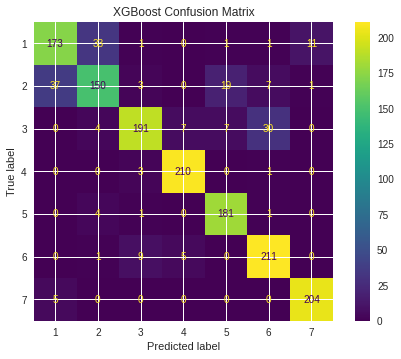

In [24]:
#First, evaluate XGBoost model on the original data (no subsetting)
print("XGBoost with original data accuracy:", clf_xg.score(dev_data_original,dev_labels_original))
# Plot Confusion Matrix
plot_confusion_matrix(clf_xg, dev_data_original, dev_labels_original, values_format = "d")
plt.title("XGBoost Confusion Matrix")
plt.plot()
print('\n\n')

In [25]:
#Evaluate XGBoost model with the submodels.
xgb_predictions_all_data = xgb_model_all_data.predict(dev_data_12_36_4_5_7)
print("Xgboost Perforamance (against 12/36 dev labels) - Model 1: ", accuracy_score(np.array(dev_labels_12_36_4_5_7), xgb_predictions_all_data))

# Retrieve examples where the model predicted 12 or 36
xgboost_predicted_12_indicies = np.where(xgb_predictions_all_data==12)
xgboost_predicted_36_indicies = np.where(xgb_predictions_all_data==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
xgboost_predictions_1_2 = xgb_model_cover_type_12.predict(np.array(dev_data_12_36_4_5_7)[xgboost_predicted_12_indicies])
xgboost_predictions_3_6 = xgb_model_cover_type_36.predict(np.array(dev_data_12_36_4_5_7)[xgboost_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
xgb_predictions_all_data[xgboost_predicted_12_indicies] = xgboost_predictions_1_2
xgb_predictions_all_data[xgboost_predicted_36_indicies] = xgboost_predictions_3_6

print("Xgboost Perforamance Against Real Dev Labels - Overall Score: ",  accuracy_score(np.array(dev_labels_original).reshape(-1, 1), xgb_predictions_all_data.reshape(-1, 1)))



Xgboost Perforamance (against 12/36 dev labels) - Model 1:  0.9503968253968254
Xgboost Perforamance Against Real Dev Labels - Overall Score:  0.9312169312169312


#### Observation on XGBoost model:

Without subsetting, xgboost algorithm works very well for the dev data, showing an accuracy above 86%, which is 3% better than the 2nd best performer, or the MLP model. With subsetting and training submodels for type 1 and 2, and 3 and 6, the accuracy on the dev data has imrpoved to over 94%. However, when applied to the "testing data" in Kaggle, the accuracy dropped back to 75%. Still 1% higher than that from MLP model, but the difference is small. Also, there is small decrease in model accuracy in "testing data" when we train one model compared to training separate models and consolidate.


#### Evaluate KNN Model

In [26]:
knn_predictions_all_data = knn_model_all_data.predict(dev_data_12_36_4_5_7)
print("KNN Perforamance (against 12/36 dev labels) - Model 1: ", accuracy_score(np.array(dev_labels_12_36_4_5_7), knn_predictions_all_data))

# Retrieve examples where the model predicted 12 or 36
knn_predicted_12_indicies = np.where(knn_predictions_all_data==12)
knn_predicted_36_indicies = np.where(knn_predictions_all_data==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
knn_predictions_1_2 = knn_model_cover_type_12.predict(np.array(dev_data_12_36_4_5_7)[knn_predicted_12_indicies])
knn_predictions_3_6 = knn_model_cover_type_36.predict(np.array(dev_data_12_36_4_5_7)[knn_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
knn_predictions_all_data[knn_predicted_12_indicies] = knn_predictions_1_2
knn_predictions_all_data[knn_predicted_36_indicies] = knn_predictions_3_6

print("KNN Perforamance Against Real Dev Labels - Overall Score: ",  accuracy_score(np.array(dev_labels_original).reshape(-1, 1), knn_predictions_all_data.reshape(-1, 1)))

KNN Perforamance (against 12/36 dev labels) - Model 1:  0.9252645502645502
KNN Perforamance Against Real Dev Labels - Overall Score:  0.9093915343915344


#### Evaluate MLP Model

In [27]:
mlp_predictions_all_data = mlp_model_all_data.predict(dev_data_12_36_4_5_7)
print("MLP Perforamance (against 12/36 dev labels)- Model 1: ", accuracy_score(np.array(dev_labels_12_36_4_5_7), mlp_predictions_all_data))

# Retrieve examples where the model predicted 12 or 36
mlp_predicted_12_indicies = np.where(mlp_predictions_all_data==12)
mlp_predicted_36_indicies = np.where(mlp_predictions_all_data==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
mlp_predictions_1_2 = knn_model_cover_type_12.predict(np.array(dev_data_12_36_4_5_7)[mlp_predicted_12_indicies])
mlp_predictions_3_6 = knn_model_cover_type_36.predict(np.array(dev_data_12_36_4_5_7)[mlp_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
mlp_predictions_all_data[mlp_predicted_12_indicies] = mlp_predictions_1_2
mlp_predictions_all_data[mlp_predicted_36_indicies] = mlp_predictions_3_6

print("MLP Perforamance Against Real Dev Labels - Overall Score: ",  accuracy_score(np.array(dev_labels_original).reshape(-1, 1), mlp_predictions_all_data.reshape(-1, 1)))

MLP Perforamance (against 12/36 dev labels)- Model 1:  0.9431216931216931
MLP Perforamance Against Real Dev Labels - Overall Score:  0.9272486772486772


#### Evaluate MLP Model with PCA transformation on original training labels

accuracy: 0.7936507936507936





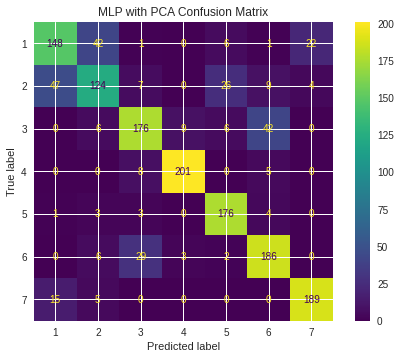

In [28]:
#This is to check the impact of PCA transformaiton. 
print("MLP model with PCA on original data accuracy:", mlp_model_all_data_pca.score(new_dev_data,dev_labels_original))
# Plot Confusion Matrix
plot_confusion_matrix(mlp_model_all_data_pca, new_dev_data, dev_labels_original, values_format = "d")
plt.title("MLP with PCA Confusion Matrix")
plt.plot()
print('\n\n')

#### Evaluate MLP Model with no PCA transformation on original training labels

accuracy: 0.8617724867724867





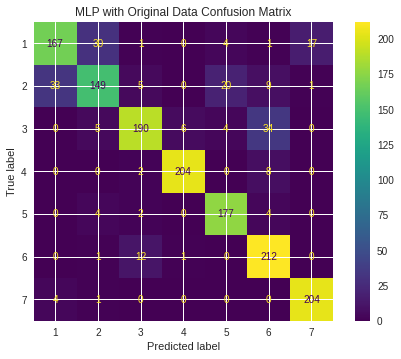

In [29]:
#This is for direct comparsion with the MLP model with PCA transformation.
print("MLP on original data accuracy:", mlp_model_all_data_original.score(dev_data_original,dev_labels_original))
# Plot Confusion Matrix
plot_confusion_matrix(mlp_model_all_data_original, dev_data_original, dev_labels_original, values_format = "d")
plt.title("MLP with Original Data Confusion Matrix")
plt.plot()
print('\n\n')

#### Observations on MLP Models:
Without training sub-models for type 1 and 2, type 3 and 6, and without applying PCA transformaiton, the accuracy of the MLP model on dev data is 83.7%. With PCA transformation on the continuous numerical variables, accuracy actually decreased to 80.2%. With separate sub-model training, accuracy on the dev data improved to 91.9%. 

#### Evaluate Neural Network (will replace MLP if it performs better)
##### TODO: Work In Progress

In [25]:
# Retrieve predictions for dev_data with labels 12,36,4,5,7
nn_predictions_all_data = nn_model_all(dev_data_12_36_4_5_7.to_numpy())

# Retrieve examples where the model predicted 12 or 36
nn_predictioned_12_indicies = np.where(nn_predictions_all_data==12)
nn_predictioned_36_indicies = np.where(nn_predictions_all_data==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
nn_predictions_1_2 = nn_model_12(np.array(dev_data_12_36_4_5_7)[nn_predictioned_12_indicies].to_numpy())
nn_predictions_3_6 = nn_model_36(np.array(dev_data_12_36_4_5_7)[nn_predictioned_36_indicies].to_numpy())

# Update those 12 or 36 labels to be 1,2,3,6
nn_predictions_all_data[nn_predictioned_12_indicies] = nn_predictions_1_2
nn_predictions_all_data[nn_predictioned_36_indicies] = nn_predictions_3_6

# # Convert logits to probabilities for 12,36,4,5,7
# tf.nn.softmax(predictions).numpy()
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer='adam',
#               loss=loss_fn,
#               metrics=['accuracy'])

# # Retrieve predictions
# predictions = model(train_data_12_36_4_5_7.to_numpy())



# model.evaluate(dev_data_12_36_4_5_7.to_numpy(), dev_labels.to_numpy(), verbose=2)

NameError: name 'nn_model_all' is not defined

#### Ensemble
Here we will combine the three best performing models and implement a "voting" system to try to improve accuracy.
<img src="data/ensemble.png">

In [30]:
#A manual Ensemble of knn, random forest, mlp and xgboost results
new_predictions = models.ensemble(knn_predictions_all_data ,forest_predictions_all_data, mlp_predictions_all_data,xgb_predictions_all_data,ada_predictions_all_data)
accuracy = accuracy_score(dev_labels_original, new_predictions)
print("Ensemble Accuracy: ", accuracy)

Models disagreed on 1047/1512 examples.
Ensemble Accuracy:  0.9345238095238095


### Test Results

In [31]:
# Read in testing data 
test_data = pd.read_csv("data/test.csv")

# Preserve testing df ID for submission purpose
test_df_id = test_data["Id"]

In [32]:
# Apply Same Transformations 
test_data = fe.manipulate_data(test_data)
test_data = fe.scale_non_training_data(standardize_features, test_data, train_data_original_scaler)
test_data = fe.drop_unseen_soil_types(test_data)


In [33]:
# Verify shape
print("Testing data shape: ", test_data.shape)

Testing data shape:  (565892, 48)


#### Test Random Forest

In [34]:
test_forest_predictions = forest_model_all_data.predict(test_data)

# Retrieve examples where the model predicted 12 or 36
test_forest_predicted_12_indicies = np.where(test_forest_predictions==12)
test_forest_predicted_36_indicies = np.where(test_forest_predictions==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
test_forest_predictions_1_2 = forest_model_cover_type_12.predict(np.array(test_data)[test_forest_predicted_12_indicies])
test_forest_predictions_3_6 = forest_model_cover_type_36.predict(np.array(test_data)[test_forest_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
test_forest_predictions[test_forest_predicted_12_indicies] = test_forest_predictions_1_2
test_forest_predictions[test_forest_predicted_36_indicies] = test_forest_predictions_3_6

#### Test KNN

In [35]:
test_knn_predictions = knn_model_all_data.predict(test_data)

# Retrieve examples where the model predicted 12 or 36
test_knn_predicted_12_indicies = np.where(test_knn_predictions==12)
test_knn_predicted_36_indicies = np.where(test_knn_predictions==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
# test_knn_predictions_1_2 = knn_model_cover_type_12.predict(np.array(test_data)[test_knn_predicted_12_indicies])
# test_knn_predictions_3_6 = knn_model_cover_type_36.predict(np.array(test_data)[test_knn_predicted_36_indicies])

test_knn_predictions_1_2 = xgb_model_cover_type_12.predict(np.array(test_data)[test_knn_predicted_12_indicies])
test_knn_predictions_3_6 = xgb_model_cover_type_36.predict(np.array(test_data)[test_knn_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
test_knn_predictions[test_knn_predicted_12_indicies] = test_knn_predictions_1_2
test_knn_predictions[test_knn_predicted_36_indicies] = test_knn_predictions_3_6

In [36]:
#test plain-vanilla knn model with original data(no subsetting) and generate submission file
test_knn_org_predictions = clf_knn.predict(test_data)
knn_res = pd.DataFrame.from_dict(dict(zip(test_df_id.to_list(),test_knn_org_predictions)), orient='index', columns=["Cover_Type"])
knn_res.to_csv(f"submissions/knn_submission.csv",index_label="Id")

#### Test Adaboost

In [37]:
test_ada_predictions = clf_ada.predict(test_data)

#### Test MLP

In [38]:
test_mlp_predictions = mlp_model_all_data.predict(test_data)

# Retrieve examples where the model predicted 12 or 36
test_mlp_predicted_12_indicies = np.where(test_mlp_predictions==12)
test_mlp_predicted_36_indicies = np.where(test_mlp_predictions==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
test_mlp_predictions_1_2 = mlp_model_cover_type_12.predict(np.array(test_data)[test_mlp_predicted_12_indicies])
test_mlp_predictions_3_6 = mlp_model_cover_type_36.predict(np.array(test_data)[test_mlp_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
test_mlp_predictions[test_mlp_predicted_12_indicies] = test_mlp_predictions_1_2
test_mlp_predictions[test_mlp_predicted_36_indicies] = test_mlp_predictions_3_6

#### Test XGBoost Ensemble

In [39]:
#test plain-vanilla xgboost model with original data(no subsetting) and generate submission file
test_xg_predictions = clf_xg.predict(test_data)
xg_res = pd.DataFrame.from_dict(dict(zip(test_df_id.to_list(),test_xg_predictions)), orient='index', columns=["Cover_Type"])
xg_res.to_csv(f"submissions/xgb_submission.csv",index_label="Id")

#### Test XGBoost Ensemble with Submodels

In [40]:
test_xgb_predictions = xgb_model_all_data.predict(test_data)

# Retrieve examples where the model predicted 12 or 36
test_xgb_predicted_12_indicies = np.where(test_xgb_predictions==12)
test_xgb_predicted_36_indicies = np.where(test_xgb_predictions==36)

# Use specific sub-models to differentiate between 1 and 2 -and- 3 and 6
test_xgb_predictions_1_2 = xgb_model_cover_type_12.predict(np.array(test_data)[test_xgb_predicted_12_indicies])
test_xgb_predictions_3_6 = xgb_model_cover_type_36.predict(np.array(test_data)[test_xgb_predicted_36_indicies])

# Update those 12 or 36 labels to be 1,2,3,6
test_xgb_predictions[test_xgb_predicted_12_indicies] = test_xgb_predictions_1_2
test_xgb_predictions[test_xgb_predicted_36_indicies] = test_xgb_predictions_3_6

pd.DataFrame.from_dict(dict(zip(test_df_id.to_list(),test_xgb_predictions)), orient='index', columns=["Cover_Type"]).to_csv(f"submissions/xgb_submission_submodels.csv",index_label="Id")

#### Test NN (will replace MLP if it performs better)

In [ ]:
# TODO once evaluate is done (do the same thing on the test data)

#### Test Ensemble

In [41]:
new_predictions = models.ensemble(test_knn_predictions,test_forest_predictions, test_mlp_predictions,test_xg_predictions,test_ada_predictions)

Models disagreed on 307676/565892 examples.


#### Generate Submission File

In [42]:
result = pd.DataFrame.from_dict(dict(zip(test_df_id.to_list(),new_predictions)), orient='index', columns=["Cover_Type"])
result.to_csv(f"submissions/cosolidated_submission.csv",index_label="Id")

### End matter

#### Acknowledgements/Sources

* That helpful stack overflow post
  * https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
* Relevant Documentation
  * KNeighborsClassifier
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  * Pretty Confusion Matrix
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  * Preprocessing
    * https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
* Soil information
  * https://www.uidaho.edu/cals/soil-orders/aridisols
* Adaboost Tuning
    * https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20
  
#### Backup Formats

*because sometimes you just want to look at the markdown or whatever real quick*

In [43]:
#Create a backup of the jupyter notebook in a format for where changes are easier to see.
!jupyter nbconvert clear_cut_solution.ipynb --to="python" --output="backups/clear_cut_solution"
!jupyter nbconvert clear_cut_solution.ipynb --to markdown --output="backups/clear_cut_solution"

# Also archiving this bad boy
!jupyter nbconvert clear_cut_solution.ipynb --to html --output="backups/clear_cut_solution"

[NbConvertApp] Converting notebook clear_cut_solution.ipynb to python
[NbConvertApp] Writing 37609 bytes to backups/clear_cut_solution.py
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to markdown
[NbConvertApp] Support files will be in backups/clear_cut_solution_files/
[NbConvertApp] Making directory backups/clear_cut_solution_files/backups
[NbConvertApp] Making directory backups/clear_cut_solution_files/backups
[NbConvertApp] Making directory backups/clear_cut_solution_files/backups
[NbConvertApp] Making directory backups/clear_cut_solution_files/backups
[NbConvertApp] Making directory backups/clear_cut_solution_files/backups
[NbConvertApp] Writing 45235 bytes to backups/clear_cut_solution.md
[NbConvertApp] Converting notebook clear_cut_solution.ipynb to html
[NbConvertApp] Writing 1029347 bytes to backups/clear_cut_solution.html
